# Conditional Variational Autoencoder

\begin{align}
\log p(x) &= \log \int_z dz q(z | x) \frac{p(x|z) p(z)}{q(x|z)} \\
&\ge \int_z dz q(z | x) \log  \frac{p(x|z) p(z)}{q(x|z)} \\
&= \mathbb{E}_{Z \sim q(z|x)} [\log p(x|Z)] - \mathbf{D}_{KL} (q(Z|x) || p(Z))
\end{align}

학습 데이타를 잘 반영한다는 것은 maximum likelihood 처리와 비슷하게 $\prod_{x \in D} p(x)$를 최대화 하는 확률밀도함수 p(x)를 찾는 것이다. $\log$를 취하면, $\mathbb{E}_{X \sim D} \log p(X)$로 쓸 수 있다. 우변의 첫 항은 decoder에서 두번 째 항은 encoder와 관련되어 있다.

CVAE의 구현을 위한 기초 코드로 Reference 5를 따랐다.

# 1. Required modules

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Loading the MNIST data

In [2]:
class MNISTOneHot(torch.utils.data.Dataset):
    def __init__(self, train=True):
        super().__init__()
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            partial(torch.reshape, shape=(-1,)),
        ])
        
        self.raw = datasets.MNIST(
            root='./data',
            train=train,
            download=True,
            transform=self.transform
        )
        
    def __len__(self):
        return len(self.raw)
    
    def __getitem__(self, idx):
        one_hot = torch.zeros(10, dtype=torch.float32)
        one_hot[self.raw[idx][1]] = 1.0
        return torch.cat([self.raw[idx][0], one_hot]), one_hot

In [3]:
batch_size = 128

# Training dataset
train_loader = torch.utils.data.DataLoader(
    MNISTOneHot(train=True),
    batch_size=batch_size,
    shuffle=True)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    MNISTOneHot(train=False),
    batch_size=batch_size,
    shuffle=False)

# sample, imags shape batch_size x (28*28)+10
for imgs, targets in train_loader:
    print(imgs.shape, targets.shape)
    break

torch.Size([128, 794]) torch.Size([128, 10])


In [4]:
a = torch.randn(2, 4)
b = torch.randn(2, 2)
torch.cat([a, b], axis=1)

tensor([[-0.4391,  0.1862, -0.7818,  1.1978, -1.1182, -0.3250],
        [ 0.5195, -0.2292,  0.8251, -0.9126,  0.1730,  0.8120]])

## 3. Building a conditional variational autoencoder model

In [5]:
class CVAE(nn.Module):
    def __init__(self, nx, ny, nh, nz):
        super().__init__()
        
        self.nz = nz
        
        # encoder
        self.fc11 = nn.Linear(nx + ny, nh)
        self.mu = nn.Linear(nh, nz)
        self.log_var = nn.Linear(nh, nz)
        
        # decoder
        self.fc21 = nn.Linear(nz + ny, nh)
        self.fc22 = nn.Linear(nh, nx + ny)
        
    def encoder(self, x):
        h = F.relu(self.fc11(x))
        return self.mu(h), self.log_var(h)
    
    def decoder(self, z, y):
        z = torch.cat([z, y], axis=1)
        h = F.relu(self.fc21(z))
        return torch.sigmoid(self.fc22(h))
    
    def sample_z(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def forward(self, x, y):
        mu, log_var = self.encoder(x)
        z = self.sample_z(mu, log_var)
        return self.decoder(z, y), mu, log_var
    

cvae = CVAE(nx=784, ny=10, nh=512, nz=2)
cvae.to(device)
cvae

CVAE(
  (fc11): Linear(in_features=794, out_features=512, bias=True)
  (mu): Linear(in_features=512, out_features=2, bias=True)
  (log_var): Linear(in_features=512, out_features=2, bias=True)
  (fc21): Linear(in_features=12, out_features=512, bias=True)
  (fc22): Linear(in_features=512, out_features=794, bias=True)
)

\begin{align}
\mathcal{D}_{KL} [ \mathcal{N} (\mu_0, \Sigma_0) || \mathcal{N} (0, I)] = \frac{1}{2} \sum_k \left( \exp(\Sigma(X)) + \mu^2 (X) - 1 - \Sigma(X)\right)
\end{align}

#### Non-negative Kullback-Leibler divergence

\begin{align}
\mathcal{D}_{KL} &= \mathbb{E}_{P} \log \frac{P}{Q} \\
&= \mathbb{E}_{P} \left(- \log \frac{Q}{P} \right) \\
&\stackrel{\text{Jensen's inequility}}{\ge} -log \mathbb{E}_{P} \frac{Q}{P} \; \because -\log(x) \; \text{is a convex function}\\
&= - \log 1 \\
&= 0
\end{align}

In [6]:
optimizer = optim.Adam(cvae.parameters())


def loss_function(recon_x, x, mu, log_var):
    BCE = -F.binary_cross_entropy(recon_x, x, reduction='sum')
    DKL = 0.5 * torch.sum(log_var.exp() + mu.pow(2) - 1 - log_var)
    return -(BCE - DKL)  # first minus sign to maximize

def train(epoch):
    cvae.train()
    train_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = cvae(x, y)
        loss = loss_function(recon_batch, x, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    return train_loss / len(train_loader.dataset)

In [7]:
from tqdm import tqdm

epochs = 20

pbar = tqdm(range(epochs))
for epoch in pbar:
    loss = train(epoch)
    pbar.set_description(f'Epoch: {epoch + 1}, loss: {loss:.2f}')

Epoch: 20, loss: 131.12: 100%|██████████| 20/20 [03:03<00:00,  9.16s/it]


In [8]:
number = 5

with torch.no_grad():
    z = torch.randn(5, 2, dtype=torch.float32).to(device)
    one_hot = torch.zeros(5, 10, dtype=torch.float32).to(device)
    one_hot[:, number] = 1.0
    sample = cvae.decoder(z, one_hot).cpu()
    sample = sample[:, :-10]

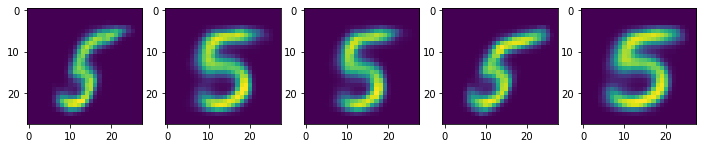

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(1, 5, figsize=(12, 3))
for i, ax in enumerate(axs):
    ax.imshow(sample[i].view(28, -1))

## Reference

1. D. Carl, Tutorial on variational autoencoders, arXiv:1606.05908v2, 2016
2. R.G. Krishnan, U. Shalit, D. Sontag, Deep Kalman Filters, arXiv:1511.05121v2, 2015
3. J. Duchi, [Derivations for linear algebra and optimization](http://web.stanford.edu/~jduchi/projects/general_notes.pdf)
4. A. Kristladl, [Variational autoencoder: intuition and implementation](https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/), blog post 2016
5. https://github.com/lyeoni/pytorch-mnist-VAE
6. [mxnet variational autoencoder example](https://github.com/apache/incubator-mxnet/tree/master/example/autoencoder/variational_autoencoder)